In [17]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
import torchvision.transforms as transforms
import time

In [18]:
!pip install pytorch-ignite

In [19]:
from ignite.handlers import FastaiLRFinder
from ignite.engine import create_supervised_trainer

In [20]:
DEVICE = 'cuda'
BATCH_SIZE = 64

### Helper functions

In [21]:
def plot_accuracy(stats, title=None):

  epochs = [item['epoch'] for item in stats]
  train_accs = [item['train_acc'] for item in stats]
  val_accs = [item['val_acc'] for item in stats]

  plt.plot(epochs, train_accs, label='Train Acc')
  plt.plot(epochs, val_accs, label=f'Val Acc [Best: {max(val_accs):.2f}%]')
  plt.legend()

  if title:
    plt.title(title)

In [22]:
def eval_accuracy(model, loader):

    epoch_acc = 0

    model.eval()

    num_corr_pred = 0
    num_total_pred = 0

    with torch.no_grad():

        for x, y in loader:

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)

            top_pred = y_pred.argmax(1)
            num_corr_pred += (top_pred == y).sum()
            num_total_pred += len(y)

    acc = num_corr_pred / num_total_pred * 100

    return acc.item()

In [23]:
def train(model, train_loader, optimizer, criterion, num_epochs, val_loader=None):

  '''
  Trains the model on the dataloader for a given number of epochs
   '''

  print('===== Start training ===== \n')

  model.train()

  start = time.time()

  stats = []

  for epoch in range(1, num_epochs+1):

    epoch_loss = 0

    for x, y in train_loader:

      optimizer.zero_grad()

      x = x.to(DEVICE)
      y = y.to(DEVICE)

      y_pred = model(x)

      loss = criterion(y_pred, y)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    print(f'[{epoch}] Loss: {epoch_loss:.3f}')

    if epoch % 5 == 0:
      train_acc = eval_accuracy(model, train_loader)
      if val_loader:
        val_acc = eval_accuracy(model, val_loader)
        print(f'[{epoch}] Train Acc: {train_acc:.2f}%  /  Val Acc: {val_acc:.2f}%')
        stats.append({'epoch': epoch, 'train_acc': train_acc, 'val_acc': val_acc})
      else:
        print(f'[{epoch}] Train Acc: {train_acc:.2f}%')
        stats.append({'epoch': epoch, 'train_acc': train_acc})


  end = time.time()
  elapsed_time = end - start

  print()
  print('===== Finished training ===== ')
  print(f'Elapsed time in minutes: {elapsed_time/60:.2f}')

  return stats

### Prepare the datasets

In [24]:
train_transforms = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.Resize(256),
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.Flowers102('data/', download=True, split='train', transform=train_transforms)
val_dataset = torchvision.datasets.Flowers102('data/', download=True, split='val', transform=test_transforms)
test_dataset = torchvision.datasets.Flowers102('data/', download=True, split='test', transform=test_transforms)

In [25]:
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

### Prepare the pretrained EfficientNet model

In [26]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

model.classifier.fc = nn.Linear(1280, 102)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [27]:
model = model.to(DEVICE)

### LR range test

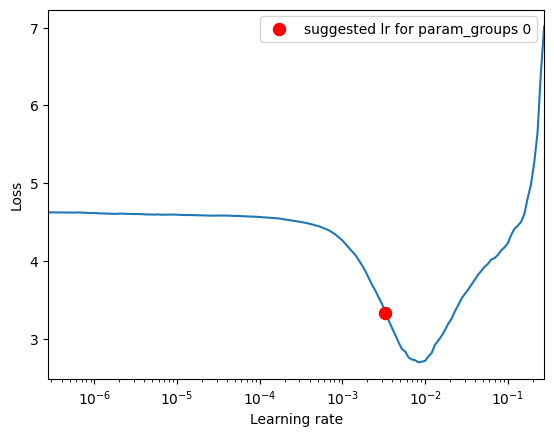

0.0033113112148259074

In [28]:
start_lr = 1e-7
end_lr = 1e+1
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainer = create_supervised_trainer(model, optimizer, criterion, DEVICE)

lr_finder = FastaiLRFinder()
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save, start_lr=start_lr, end_lr=end_lr, num_iter=200) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

# Get lr_finder results
lr_finder.get_results()

# Plot lr_finder results (requires matplotlib)
lr_finder.plot()

# get lr_finder suggestion for lr
lr_finder.lr_suggestion()

### Train the model

In [29]:
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
stats = train(model, train_loader, optimizer, criterion, num_epochs, val_loader)

===== Start training ===== 

[1] Loss: 73.728
[2] Loss: 71.558
[3] Loss: 69.079
[4] Loss: 66.034
[5] Loss: 61.962
[5] Train Acc: 43.04%  /  Val Acc: 35.29%
[6] Loss: 45.419
[7] Loss: 19.875
[8] Loss: 11.888
[9] Loss: 7.644
[10] Loss: 5.338
[10] Train Acc: 92.75%  /  Val Acc: 86.18%
[11] Loss: 4.517
[12] Loss: 4.113
[13] Loss: 3.795
[14] Loss: 3.331
[15] Loss: 2.737
[15] Train Acc: 95.59%  /  Val Acc: 87.55%
[16] Loss: 3.121
[17] Loss: 2.405
[18] Loss: 2.382
[19] Loss: 1.740
[20] Loss: 2.383
[20] Train Acc: 96.96%  /  Val Acc: 89.61%
[21] Loss: 2.364
[22] Loss: 2.121
[23] Loss: 2.257
[24] Loss: 1.825
[25] Loss: 2.067
[25] Train Acc: 97.65%  /  Val Acc: 90.49%
[26] Loss: 1.912
[27] Loss: 2.116
[28] Loss: 1.694
[29] Loss: 1.635
[30] Loss: 2.418
[30] Train Acc: 97.16%  /  Val Acc: 91.27%
[31] Loss: 1.686
[32] Loss: 2.024
[33] Loss: 1.508
[34] Loss: 1.298
[35] Loss: 1.050
[35] Train Acc: 97.45%  /  Val Acc: 91.27%
[36] Loss: 1.745
[37] Loss: 1.758
[38] Loss: 2.076
[39] Loss: 1.581
[40] Loss

### Plot accuracy

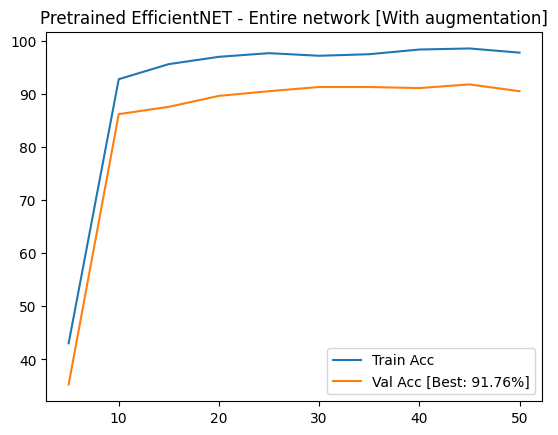

In [ ]:
plot_accuracy(stats, title='Pretrained EfficientNET - Entire network [With augmentation]')

In [ ]:
test_acc = eval_accuracy(model, test_loader)
print(f'Accuracy on the test set (final model): {test_acc:.2f}%')

Accuracy on the test set (final model): 87.62%
